In [1]:
import numpy as np
from network import *

import pickle

# Data Augmentation
256x256 crop random 224x224 5개<br/>
좌우 반전하여 10개 생성<br/>

RGB pixel에 PCA를 하고, Gaussian dist(0, 0.1)을 곱하고 원래 픽셀에 더함

In [2]:
%matplotlib inline
import os
import cv2
import random
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA

# path = "/home/heim/dataset/ilsvrc12/"
path = "/home/heim/mount_disk/workspace/datasets/ilsvrc12/train/"

num_class = 1000

def gether_data(batch_size):
    x_batch = []
    y_batch = []
    
    for i in range(batch_size):
        y = np.random.randint(0,num_class)
        data_path = path+str(os.listdir(path)[y])+"/"
        data_path +=random.choice(os.listdir(data_path))
        im = cv2.imread(data_path).astype(float)
        # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        t = int(im.shape[0]>im.shape[1])
        diff = im.shape[1]-im.shape[0]
        im = im[-t*int(diff/2):im.shape[0]+t*int(diff/2),(1-t)*int(diff/2):im.shape[1]-(1-t)*int(diff/2),:]
#         im = cv2.resize(im, (256,256))
        
#         pos_x, pos_y = [[0,0],[2,2],[1,1],[0,2],[2,0]][np.random.randint(0,5)]
        
#         im = im[16*pos_x:256-16*(2-pos_x),16*pos_y:256-16*(2-pos_y),:]

        im = cv2.resize(im, (225,225))
        
        if np.random.randint(0,2):
            im = cv2.flip(im, 1)
        # plt.imshow(im)
        # plt.show()
        
        im =(im-np.array([[179.25, 172.94, 172.49]]))
        x_batch.append(im)
        y_batch.append(y)
    
    return np.array(x_batch).transpose(0,3,1,2), one_hot_encoder(np.array(y_batch),num_class)

In [3]:
gether_data(1)[0].shape

(1, 3, 225, 225)

(2, 3, 225, 225) (2, 1000)
(225, 225, 3)


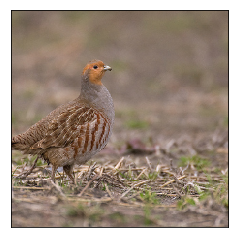

In [4]:
x_batch, y_batch = gether_data(2)
print(x_batch.shape,y_batch.shape)

from matplotlib import pyplot as plt 
im = gether_data(1)[0][0].transpose(1,2,0) + np.array([[179.25, 172.94, 172.49]])
im = np.abs(im).astype(np.int)
b, g, r = im[:,:,0], im[:,:,1], im[:,:,2]
im  = np.array([r,g,b]).transpose(1,2,0)
print(im.shape)
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

# Network structure
Total 8 weight layers

**5 Convolution layers**

        Conv 1 : 7x7x3, 96 kernels, stride=2, pad=0
            ReLU
            MaxPool 1 : 3x3, stride=2
        Conv 2 : 5x5x96, 256 kernels, stride=1, pad=1
            ReLU
            MaxPool 2 : 3x3, stride=2
        Conv 3 : 3x3x256, 384 kernels, stride=1, pad=1
            ReLU
        Conv 4 : 3x3x384, 384 kernels, stride=1, pad=1
            ReLU
        Conv 5 : 3x3x384, 256 kernels, stride=1, pad=1
            ReLU
            MaxPool 3 : 3x3, stride=2
**3 Dense layers**

        Dense 1:  4096
            ReLU
            Dropout : 50 %
        Dense 2 : 4096
            ReLU
            Dropout : 50 %
        Dense 3 : 1000
    
**1000-way softmax**

In [5]:
net = Network()

initializer ="adam"
# Conv 1 : 11x11x3, 96 kernels, stride=4, pad=0
net.add(Convolution([3,225,225],[7,7],96, stride=2, pad=1, initializer=initializer))
# net.add(Convolution([3,224,224],[7,7],96, stride=2, pad=2, initializer=initializer))
net.add(Relu())
net.add(Pooling([3,3], stride=2, pad=0))

# Conv 2 : 5x5x96, 256 kernels, stride=1, pad=2
net.add(Convolution([96,55,55],[5,5],256, stride=2, pad=1, initializer=initializer))
net.add(Relu())
net.add(Pooling([3,3], stride=2))

# Conv 3 : 3x3x256, 384 kernels, stride=1, pad=1
net.add(Convolution([256,13,13],[3,3],384, pad=1, initializer=initializer))
net.add(Relu())


# Conv 4 : 3x3x384, 384 kernels, stride=1, pad=1
net.add(Convolution([384,13,13],[3,3],384, pad=1, initializer=initializer))
net.add(Relu())

# Conv 5 : 3x3x384, 256 kernels, stride=1, pad=1
net.add(Convolution([384,13,13],[3,3],256, pad=1, initializer=initializer))
net.add(Relu())
net.add(Pooling([3,3], stride=2))


net.add(Flatten())
net.add(Affine([9216,4096], initializer=initializer))
net.add(Relu())
# net.add(Dropout())
net.add(Affine([4096,4096], initializer=initializer))
net.add(Relu())
# net.add(Dropout())
net.add(Affine([4096,num_class], initializer=initializer))
net.set_loss(SoftmaxWithLoss())

i=0
out = np.ones(gether_data(1)[0].shape)
for layer in net.layers:
    out = layer.forward(out)
    print(i , layer.__class__.__name__, out.shape)
    i+=1

0 Convolution (1, 96, 111, 111)
1 Relu (1, 96, 111, 111)
2 Pooling (1, 96, 55, 55)
3 Convolution (1, 256, 27, 27)
4 Relu (1, 256, 27, 27)
5 Pooling (1, 256, 13, 13)
6 Convolution (1, 384, 13, 13)
7 Relu (1, 384, 13, 13)
8 Convolution (1, 384, 13, 13)
9 Relu (1, 384, 13, 13)
10 Convolution (1, 256, 13, 13)
11 Relu (1, 256, 13, 13)
12 Pooling (1, 256, 6, 6)
13 Flatten (1, 9216)
14 Affine (1, 4096)
15 Relu (1, 4096)
16 Affine (1, 4096)
17 Relu (1, 4096)
18 Affine (1, 1000)


# Details of Learning
- mini-batch size : 128
- momentum : 0.9, weight decay : 0.0005
- 0-mean gaussian *0.01
- dropout:0.5
- learning rate : 0.01, validation error가 멈추면 1/10배
- (7개 CNN 앙상블) 미정

In [6]:
batch_accuracy_track = []
test_accuracy_track = []
loss_track=[]

In [12]:
import time
train_size = 1200000
batch_size = 16
learning_rate=0.01
iter_per_epoch = train_size/batch_size
epochs = 1
iter_step = int(iter_per_epoch)
for epoch in range(epochs):
    start_time = time.time()
    for i in range(iter_step):
        x_batch, y_batch = gether_data(batch_size)
        loss = net.fit(x_batch, y_batch, learning_rate=learning_rate, optimizer='none')
        loss_track.append(loss)
        if i%(np.max([iter_step/100000,1]))==0:
            print("== Loss {0:0.4f}, Process : {1:0.4f}% ==".format(loss, i/iter_step*100), end="\r")
    batch_accuracy = net.accuracy(x_batch, y_batch)
    x_test, y_test = gether_data(batch_size)
    test_accuracy = net.accuracy(x_test, y_test)
    batch_accuracy_track.append(batch_accuracy)
    test_accuracy_track.append(test_accuracy)
    print("== {0} Epoch, Loss {1:0.4f}, Batch Accuracy  {2:0.4f}, Test Accuracy : {3:0.3f} == ({4:0.2f} m)".format(epoch+1, loss, batch_accuracy, test_accuracy, (time.time()-start_time)/60))

KeyboardInterrupt: 

In [9]:
x_test, y_test = gether_data(100)
net.accuracy(x_test,y_test,top=5)

0.01

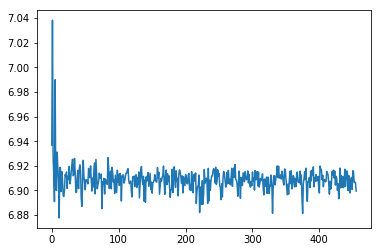

In [13]:
l_track = np.array(loss_track)
x = np.arange(l_track.size)
plt.plot(x, l_track, label="loss")
# plt.ylim([0,8])
plt.show()

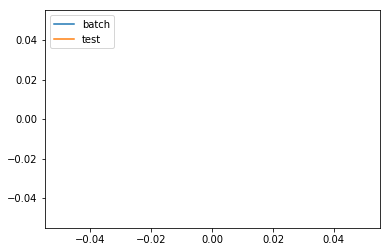

In [11]:
b_track = np.array(batch_accuracy_track)
t_track = np.array(test_accuracy_track)
x = np.arange(b_track.size)
plt.plot(x, b_track, label="batch")
plt.plot(x, t_track, label="test")
# plt.ylim([0,1])
plt.legend(loc=2)
plt.show()

In [13]:
###  SAVE ###
net.accuracy(x_batch[0:1], y_batch[0:1])
net.set_save_mode()
dump = (net.layers, batch_accuracy_track, test_accuracy_track, loss_track)
with open('zfnet.wb', 'wb') as f:
    pickle.dump(dump, f)

In [7]:
###  LOAD ###
with open('zfnet.wb', 'rb') as f:
    dump = pickle.load(f)
(net.layers, batch_accuracy_track, test_accuracy_track, loss_track) = dump

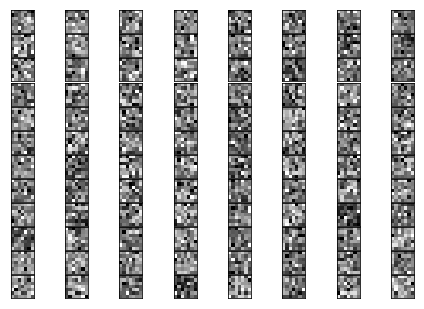

In [14]:
filter_show(net.layers[0].W)

In [11]:
net.layers[0].W[0,0,:,:]

array([[-0.00775212,  0.00661159,  0.01023701, -0.00154934, -0.00428706,
         0.01580498,  0.02583724],
       [ 0.02552661,  0.01239139,  0.00538152, -0.00654538,  0.01232342,
        -0.00355346,  0.01531495],
       [-0.00071986, -0.00680813,  0.00611425,  0.00062714, -0.0110205 ,
        -0.02201712,  0.00132061],
       [ 0.00270104,  0.00699882,  0.00229889, -0.01207997, -0.00130731,
        -0.01803141, -0.01277836],
       [ 0.00833693,  0.00379526,  0.01415033,  0.0093451 , -0.01159397,
        -0.00177384,  0.00502582],
       [-0.00639899, -0.00037694, -0.02362103,  0.00978284,  0.00058571,
        -0.00420371, -0.01169072],
       [ 0.00499977, -0.00525051,  0.01769043, -0.00251589, -0.00945282,
        -0.0081303 ,  0.00911798]])

In [25]:
net.layers[0].dW[0,0,:,:]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [30]:
net.fit(x_batch, y_batch, learning_rate=learning_rate)

6.22487328744319

In [31]:
net.layers[0].W[0,0,0,0]

0.06070977256873998

In [32]:
net.layers[0].dW[0,0,0,0]

0.0

In [45]:
np.random.normal(loc= 1.0, scale = 0.1)

1.1171495616398919